<a href="https://colab.research.google.com/github/InduMeghana/MachineLearning/blob/master/week_5_sigmoid_asgn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore") 

In [0]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = 0,std = 1)])
train_data=FashionMNIST(train = True,transform = transform,root = os.getcwd(),download = True)
test_data=FashionMNIST(train = False,transform = transform,root = os.getcwd(),download = True)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


In [0]:
print("train dataset:",train_data)
print("test dataset:",test_data)

train dataset: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )
test dataset: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [0]:
train_loader=DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
test_loader=DataLoader(test_data, batch_size=16, shuffle=True, num_workers=0)
train_iter=iter(train_loader)
train_batch=next(train_iter)

In [0]:
for item in train_batch:
  print(item.size())

torch.Size([16, 1, 28, 28])
torch.Size([16])


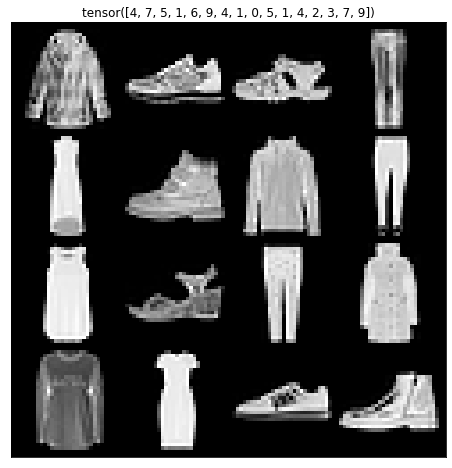

In [0]:
def plot_images(batch):
  img_grid=make_grid(batch[0],nrow=4)
  img_np=img_grid.numpy()
  img_np=np.transpose(img_np,(1,2,0))
  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.title(batch[1])
  plt.xticks([])
  plt.yticks([])
  plt.plot()
plot_images(train_batch)

In [0]:
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [0]:
def evaluate_on_gpu(model,dataloader):
  with torch.no_grad():
    total,correct=0,0
    for batch in dataloader:
      images,labels=batch
      images,labels=images.to(device),labels.to(device)
      out_probs=model(images)
      out_labels=torch.argmax(out_probs,axis=1)
      total+=labels.size(0)
      correct+=torch.sum(labels==out_labels).item()
    acc=100*(correct/total)
    return acc
def train_on_gpu(model,loss_fun,optimizer,train_loader,test_loader,epochs=200):
  hist={"loss":[],"train_acc":[],"test_acc":[]}
  for epoch_num in tqdm(range(1,epochs+1),desc="training",total=epochs):
    losses=[]
    for batch in train_loader:
      images,labels=batch
      images,labels=images.to(device),labels.to(device)
      optimizer.zero_grad()
      out=model(images)
      loss=loss_fun(out,labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
    hist["loss"].append(np.array(losses).mean())
    if(min(hist["loss"])==(np.array(losses).mean())):
      model_weights=model.state_dict()
    train_acc=evaluate_on_gpu(model,train_loader)
    test_acc=evaluate_on_gpu(model,test_loader)
    hist["train_acc"].append(train_acc)
    hist["test_acc"].append(test_acc)
  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
  ax[0].plot(range(1,epochs+1),hist["loss"],label="loss")
  ax[0].grid()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Loss value")
  ax[0].set_title("Epochs vs Loss")
  ax[1].plot(hist["train_acc"],"b-",label="Training accuracy")
  ax[1].plot(hist["test_acc"],"m-",label="Test accuracy")    
  ax[1].grid()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Accuracy")
  ax[1].set_title("Epochs vs Loss")
  plt.show()
  torch.save(model_weights,"model_weights.pth")
  return model

In [0]:
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784,out_features=650),
    nn.Sigmoid(),
    nn.Linear(in_features=650,out_features=420),
    nn.Sigmoid(),
    nn.Linear(in_features=420,out_features=360),
    nn.Sigmoid(),
    nn.Linear(in_features=360,out_features=230),
    nn.Sigmoid(),
    nn.Linear(in_features=230,out_features=10),
    nn.Softmax(dim=1)
)
model=model.to(device)
loss_fun=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())

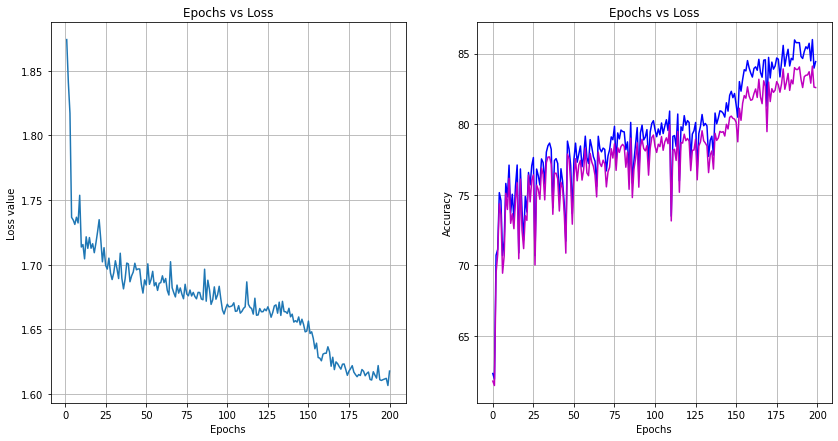

In [0]:
model=train_on_gpu(model,loss_fun,optimizer,train_loader,test_loader)